In [43]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib
import imgaug.augmenters as iaa
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras_unet.models import custom_unet
from keras_unet.metrics import iou
from keras_unet.losses import jaccard_distance
from skimage import morphology

In [44]:
tf.__version__

'2.3.1'

# Data preparation

In [45]:
CXR_TRAIN_IMAGE_BASE_PATH = '/home/daniel/dev/python/chest_x_ray/data/lung_segmentation/CXR_png'
CXR_TRAIN_MASKS_BASE_PATH = '/home/daniel/dev/python/chest_x_ray/data/lung_segmentation/masks'
MODEL_CHECKPOINT_PATH = '/home/daniel/dev/python/chest_x_ray/models/unet_grayscaled_0401.h5'

In [46]:
CXR_TRAIN_IMAGE_BASE_PATH = '/home/8cb7/kaggle_data/lung_segmentation/CXR_png/'
CXR_TRAIN_MASKS_BASE_PATH = '/home/8cb7/kaggle_data/lung_segmentation/masks/'
MODEL_CHECKPOINT_PATH = '/home/8cb7/kaggle_data/models/unet_grayscaled_0401.h5'

In [47]:
images = sorted(list(Path(os.path.join(CXR_TRAIN_IMAGE_BASE_PATH)).glob('**/*')))
masks = sorted(list(Path(os.path.join(CXR_TRAIN_MASKS_BASE_PATH)).glob('**/*')))

In [48]:
print("Amount of images: ", len(images))
print("Amount of masks: ", len(masks))

Amount of images:  800
Amount of masks:  704


In [49]:
img_mask_tuples = []

for mask_path in masks:
    for i in images:
        basename = (os.path.basename(i)).split(".")[0]
        if basename in str(mask_path):
            img_path = i
            break
    img_mask_tuples.append((str(img_path), str(mask_path)))

In [50]:
len(img_mask_tuples)

704

## Plot images and masks

In [51]:
def plot_img(img_mask_tuple):
    img_concat = np.concatenate((cv2.imread(str(img_mask_tuple[0])), cv2.imread(str(img_mask_tuple[1]))), axis=1)
    plt.axis('off')
    plt.imshow(img_concat)

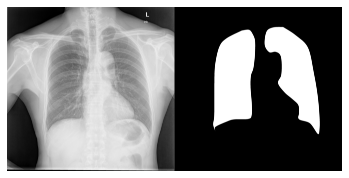

In [54]:
plot_img(img_mask_tuples[3])

In [55]:
def plot_img_matrix(img_mask_tuple_list, cols):
    # concat
    images = []
    for t in img_mask_tuple_list:
        img_concat = np.concatenate((cv2.imread(str(t[0])), cv2.imread(str(t[1]))), axis=1)
        images.append(img_concat)
    # plot
    plt.subplots(figsize=(15,5))
    if len(images) % cols == 0:
        rows = len(images) / cols
    else:
        rows = (len(images) % cols) +1
    for num, x in enumerate(images):
        plt.subplot(rows,cols,num+1)
        plt.axis('off')
        plt.imshow(x)

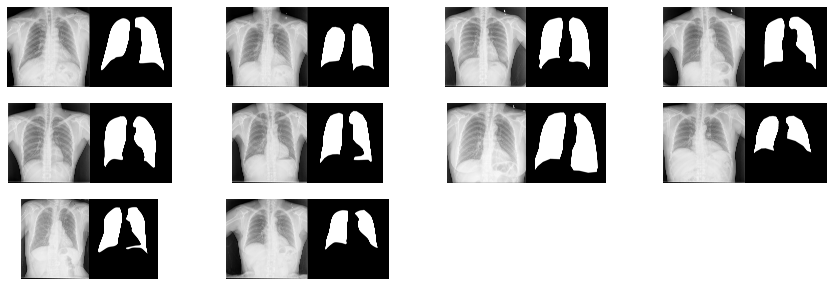

In [56]:
plot_img_matrix(img_mask_tuples[:10], 4)

In [57]:
df = pd.DataFrame(img_mask_tuples, dtype='str', columns=['img', 'mask'])
df_train = df.sample(frac=0.9, random_state=200)
df_val = df.drop(df_train.index)

df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)

In [58]:
print(len(df_train))
print(len(df_val))

634
70


## UNET

In [59]:
IMG_SIZE = 256
BATCH_SIZE = 8

In [60]:
# https://github.com/aleju/imgaug/issues/66#issuecomment-387609992
# ToDo: Fine-tune params, especially gain. cutoff should remain close to 1, 5 <= gain < 20 
aug_clahe = iaa.CLAHE(clip_limit=(4), tile_grid_size_px=(2,2))

In [61]:
def applySigmoidContrast(img):
    img = sigm_aug.augment_image(img)
    return img

In [62]:
def binarize_mask(img):
    # specify a threshold 0-255
    threshold = 255 // 2
    # make all pixels < threshold black
    return 1.0 * (img > threshold)

In [100]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)
seq_img = iaa.Sequential([
    #iaa.Fliplr(0.5),
    aug_clahe,
#     sometimes(iaa.Affine(
#            rotate=(-10, 10),
#            shear=(10,10),
#             scale={"x": (1, 1.1), "y": (1, 1.1)},
#     )),
], random_order=True)


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=BATCH_SIZE, shuffle=True, augment=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.augment = augment

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X_img, X_mask = self.__get_data(batch)
        return np.array(X_img), np.array(X_mask)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)    

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        
        X_imgs = []
        X_masks = []

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            img = img.reshape(img.shape[0], img.shape[1], 1)
            
            # Apply CLAHE
            # img = aug_clahe(image=img)

            mask = cv2.resize(cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE) ,interpolation=cv2.INTER_NEAREST)
            mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)[1]

            if (self.augment):
#                 seq_img_i = seq_img.to_deterministic()
#                 img = seq_img_i.augment_image(img)
#                 mask = seq_img_i.augment_image(mask)
                clahe = cv2.createCLAHE(clipLimit = 2.5, tileGridSize=(16,16))
                img = clahe.apply(img)
        
            # normalize / rescale
            img = img / 255.0
            mask = mask / 255.0
            X_imgs.append(img)
            X_masks.append(mask)

        return X_imgs, X_masks

In [101]:
train_generator = DataGenerator(df_train, augment=True)
val_generator = DataGenerator(df_val, augment=True)

In [102]:
example = train_generator.__getitem__(0)

In [103]:
example[0].shape

(8, 256, 256)

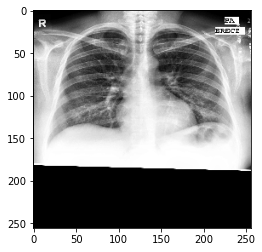

In [104]:
plt.imshow(example[0][-1,:,:], cmap="gray")

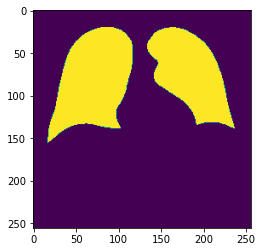

In [105]:
plt.imshow(example[1][-1,:,:])

In [106]:
import tensorflow.keras.backend as K

def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coeff(y_true, y_pred)

def dice_be(y_true, y_pred):
    dl = dice_loss(y_true, y_pred)
    bce = K.binary_crossentropy(y_true, y_pred)
    return 2.0 * dl + 1.0 * bce

In [107]:
model = custom_unet(
    input_shape=(256, 256, 1),
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=2e-4),
    # loss=dice_loss,
    loss='binary_crossentropy',
    # loss=dice_coef_loss,
    metrics=['binary_accuracy', iou]
)
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 256, 256, 64) 640         input_8[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d_35 (SpatialDr (None, 256, 256, 64) 0           conv2d_133[0][0]                 
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 256, 256, 64) 36928       spatial_dropout2d_35[0][0]       
______________________________________________________________________________________

In [108]:
mcp_save = ModelCheckpoint(MODEL_CHECKPOINT_PATH, save_best_only=True, monitor='val_iou', mode='max')
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=1, verbose=1)

In [109]:
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    epochs=20,
                    callbacks=[reduceLROnPlat])

Epoch 1/20
79/79 [==============================] - 75s 955ms/step - loss: 0.4566 - binary_accuracy: 0.7890 - iou: 0.2673 - val_loss: 0.2918 - val_binary_accuracy: 0.8611 - val_iou: 0.3618
Epoch 2/20
79/79 [==============================] - 75s 948ms/step - loss: 0.2608 - binary_accuracy: 0.8816 - iou: 0.4922 - val_loss: 0.1777 - val_binary_accuracy: 0.9290 - val_iou: 0.6525
Epoch 3/20
79/79 [==============================] - 75s 948ms/step - loss: 0.1702 - binary_accuracy: 0.9312 - iou: 0.6678 - val_loss: 0.1107 - val_binary_accuracy: 0.9585 - val_iou: 0.7757
Epoch 4/20
79/79 [==============================] - 76s 956ms/step - loss: 0.1073 - binary_accuracy: 0.9596 - iou: 0.7836 - val_loss: 0.0927 - val_binary_accuracy: 0.9646 - val_iou: 0.8027
Epoch 5/20
79/79 [==============================] - 74s 938ms/step - loss: 0.0863 - binary_accuracy: 0.9675 - iou: 0.8217 - val_loss: 0.0819 - val_binary_accuracy: 0.9686 - val_iou: 0.8128
Epoch 6/20
79/79 [==============================] - 74s

In [92]:
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    epochs=20,
                    callbacks=[reduceLROnPlat])

Epoch 1/20
79/79 [==============================] - 76s 958ms/step - loss: 0.5454 - binary_accuracy: 0.7464 - iou: 0.1770 - val_loss: 0.4315 - val_binary_accuracy: 0.8387 - val_iou: 0.2564
Epoch 2/20
79/79 [==============================] - 74s 942ms/step - loss: 0.3718 - binary_accuracy: 0.8312 - iou: 0.3586 - val_loss: 0.2623 - val_binary_accuracy: 0.8824 - val_iou: 0.4450
Epoch 3/20
79/79 [==============================] - 75s 947ms/step - loss: 0.2759 - binary_accuracy: 0.8822 - iou: 0.4944 - val_loss: 0.2337 - val_binary_accuracy: 0.8985 - val_iou: 0.5019
Epoch 4/20
79/79 [==============================] - 75s 952ms/step - loss: 0.2104 - binary_accuracy: 0.9153 - iou: 0.6013 - val_loss: 0.1346 - val_binary_accuracy: 0.9496 - val_iou: 0.7078
Epoch 5/20
79/79 [==============================] - 75s 949ms/step - loss: 0.1240 - binary_accuracy: 0.9526 - iou: 0.7517 - val_loss: 0.1055 - val_binary_accuracy: 0.9599 - val_iou: 0.7850
Epoch 6/20
79/79 [==============================] - 74s

In [72]:
history = model.fit(train_generator, 
                    validation_data=val_generator,
                    steps_per_epoch=len(train_generator),
                    validation_steps=len(val_generator),
                    epochs=20,
                    callbacks=[mcp_save, reduceLROnPlat])

Epoch 1/20
79/79 [==============================] - 74s 931ms/step - loss: 0.4211 - binary_accuracy: 0.7998 - iou: 0.3106 - val_loss: 0.2255 - val_binary_accuracy: 0.9225 - val_iou: 0.5051
Epoch 2/20
79/79 [==============================] - 74s 941ms/step - loss: 0.1594 - binary_accuracy: 0.9382 - iou: 0.6922 - val_loss: 0.1209 - val_binary_accuracy: 0.9531 - val_iou: 0.7373
Epoch 3/20
79/79 [==============================] - ETA: 0s - loss: 0.1048 - binary_accuracy: 0.9593 - iou: 0.7874
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
79/79 [==============================] - 74s 940ms/step - loss: 0.1048 - binary_accuracy: 0.9593 - iou: 0.7874 - val_loss: 0.1229 - val_binary_accuracy: 0.9530 - val_iou: 0.7620
Epoch 4/20
79/79 [==============================] - 74s 941ms/step - loss: 0.0859 - binary_accuracy: 0.9668 - iou: 0.8195 - val_loss: 0.0805 - val_binary_accuracy: 0.9693 - val_iou: 0.8212
Epoch 5/20
79/79 [==============================] - ETA: 0s 

KeyboardInterrupt: 

In [29]:
model = tf.keras.models.load_model(MODEL_CHECKPOINT_PATH, compile=False)

OSError: SavedModel file does not exist at: /home/8cb7/kaggle_data/models/unet_grayscaled_0401.h5/{saved_model.pbtxt|saved_model.pb}

In [30]:
def resize(img):
    img = cv2.resize(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [31]:
def get_pred_generator(img_list):
    df = pd.DataFrame(img_list, dtype='str', columns=['img'])
    return ImageDataGenerator().flow_from_dataframe(
        dataframe=df,
        x_col='img',
        directory=None,
        # target_size=(IMG_SIZE, IMG_SIZE),
        preprocess_function=resize,
        class_mode=None,
        color_mode='grayscale',
        batch_size=8,
    )

In [32]:
# currently not in use
def remove_small_regions(img):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    cleaned = morphology.remove_small_objects(img, min_size=64, connectivity=1)
    cleaned = morphology.remove_small_holes(img, area_threshold=64)
    return cleaned

In [33]:
def pred_and_save_masks(in_path, out_path):
    images = list(Path(os.path.join(in_path)).glob('**/*'))
    pred = model.predict(get_pred_generator(images), batch_size=8)

    # now save our pred as images
    for i in range(0,len(pred)):
        org_img = str(images[i])
        pred_mask_name = os.path.basename(org_img).rsplit('.')[0] + '_predmask.jpg'
        #mask = cv2.threshold(pred[i][:,:,0],127,255,cv2.THRESH_BINARY)[1]
        # mask = np.asarray(mask, dtype=int)
        #mask = binarize_mask(pred[i] * 255)
        # mask = np.asarray(mask, dtype=int)
        # print(mask)
        #mask = remove_small_regions(mask)
        plt.imsave(out_path + pred_mask_name, pred[i][:,:,0], cmap='gray')

## Predict and save masks

>  Important

- Please adjust the base paths BASE_MOONEY_DATA_PATH and BASE_COVID_DATA_PATH + BASE_COVID_MASKS_PATH.
- Please make sure BASE_MOONEY_DATA_PATH + /masks exists. Furthermore the test/train/val folders are required with NORMAL and PNEUMONIA as subfolders.

In [110]:
BASE_MOONEY_DATA_PATH = '/home/8cb7/.kaggle/mooney/chest_xray'
BASE_COVID_DATA_PATH = '/home/8cb7/.kaggle/covid-chestxray-dataset/output'
BASE_COVID_MASKS_PATH = '/home/8cb7/.kaggle/covid-chestxray-dataset/masks/'

In [111]:
print("Generate masks for mooney --> test")
pred_and_save_masks(BASE_MOONEY_DATA_PATH + '/test/NORMAL/', BASE_MOONEY_DATA_PATH + '/masks/test/NORMAL/')

Generate masks for mooney --> test
Found 234 validated image filenames.


In [112]:
pred_and_save_masks(BASE_MOONEY_DATA_PATH + '/test/PNEUMONIA/', BASE_MOONEY_DATA_PATH + '/masks/test/PNEUMONIA/')

Found 390 validated image filenames.


In [113]:
print("Generate masks for mooney --> train")
pred_and_save_masks(BASE_MOONEY_DATA_PATH + '/train/NORMAL/', BASE_MOONEY_DATA_PATH + '/masks/train/NORMAL/')

Generate masks for mooney --> train
Found 1341 validated image filenames.


In [114]:
pred_and_save_masks(BASE_MOONEY_DATA_PATH + '/train/PNEUMONIA/', BASE_MOONEY_DATA_PATH + '/masks/train/PNEUMONIA/')

Found 3875 validated image filenames.


In [115]:
print("Generate masks for mooney --> val")
pred_and_save_masks(BASE_MOONEY_DATA_PATH + '/val/NORMAL/', BASE_MOONEY_DATA_PATH + '/masks/val/NORMAL/')
pred_and_save_masks(BASE_MOONEY_DATA_PATH + '/val/PNEUMONIA/', BASE_MOONEY_DATA_PATH + '/masks/val/PNEUMONIA/')

Generate masks for mooney --> val
Found 8 validated image filenames.
Found 8 validated image filenames.


In [116]:
print("Generate masks for covid19")
pred_and_save_masks(BASE_COVID_DATA_PATH, BASE_COVID_MASKS_PATH)

Generate masks for covid19
Found 196 validated image filenames.
